running for the data set iris
for random 100 sample data vectors
n_qubits: 2
running for the data set covtype
for random 100 sample data vectors
n_qubits: 6
running for the data set ionosphere
for random 100 sample data vectors
n_qubits: 6
running for the data set breast_cancer
for random 100 sample data vectors
n_qubits: 5
running for the data set wine
for random 100 sample data vectors
n_qubits: 4
running for the data set digits
for random 100 sample data vectors
n_qubits: 6


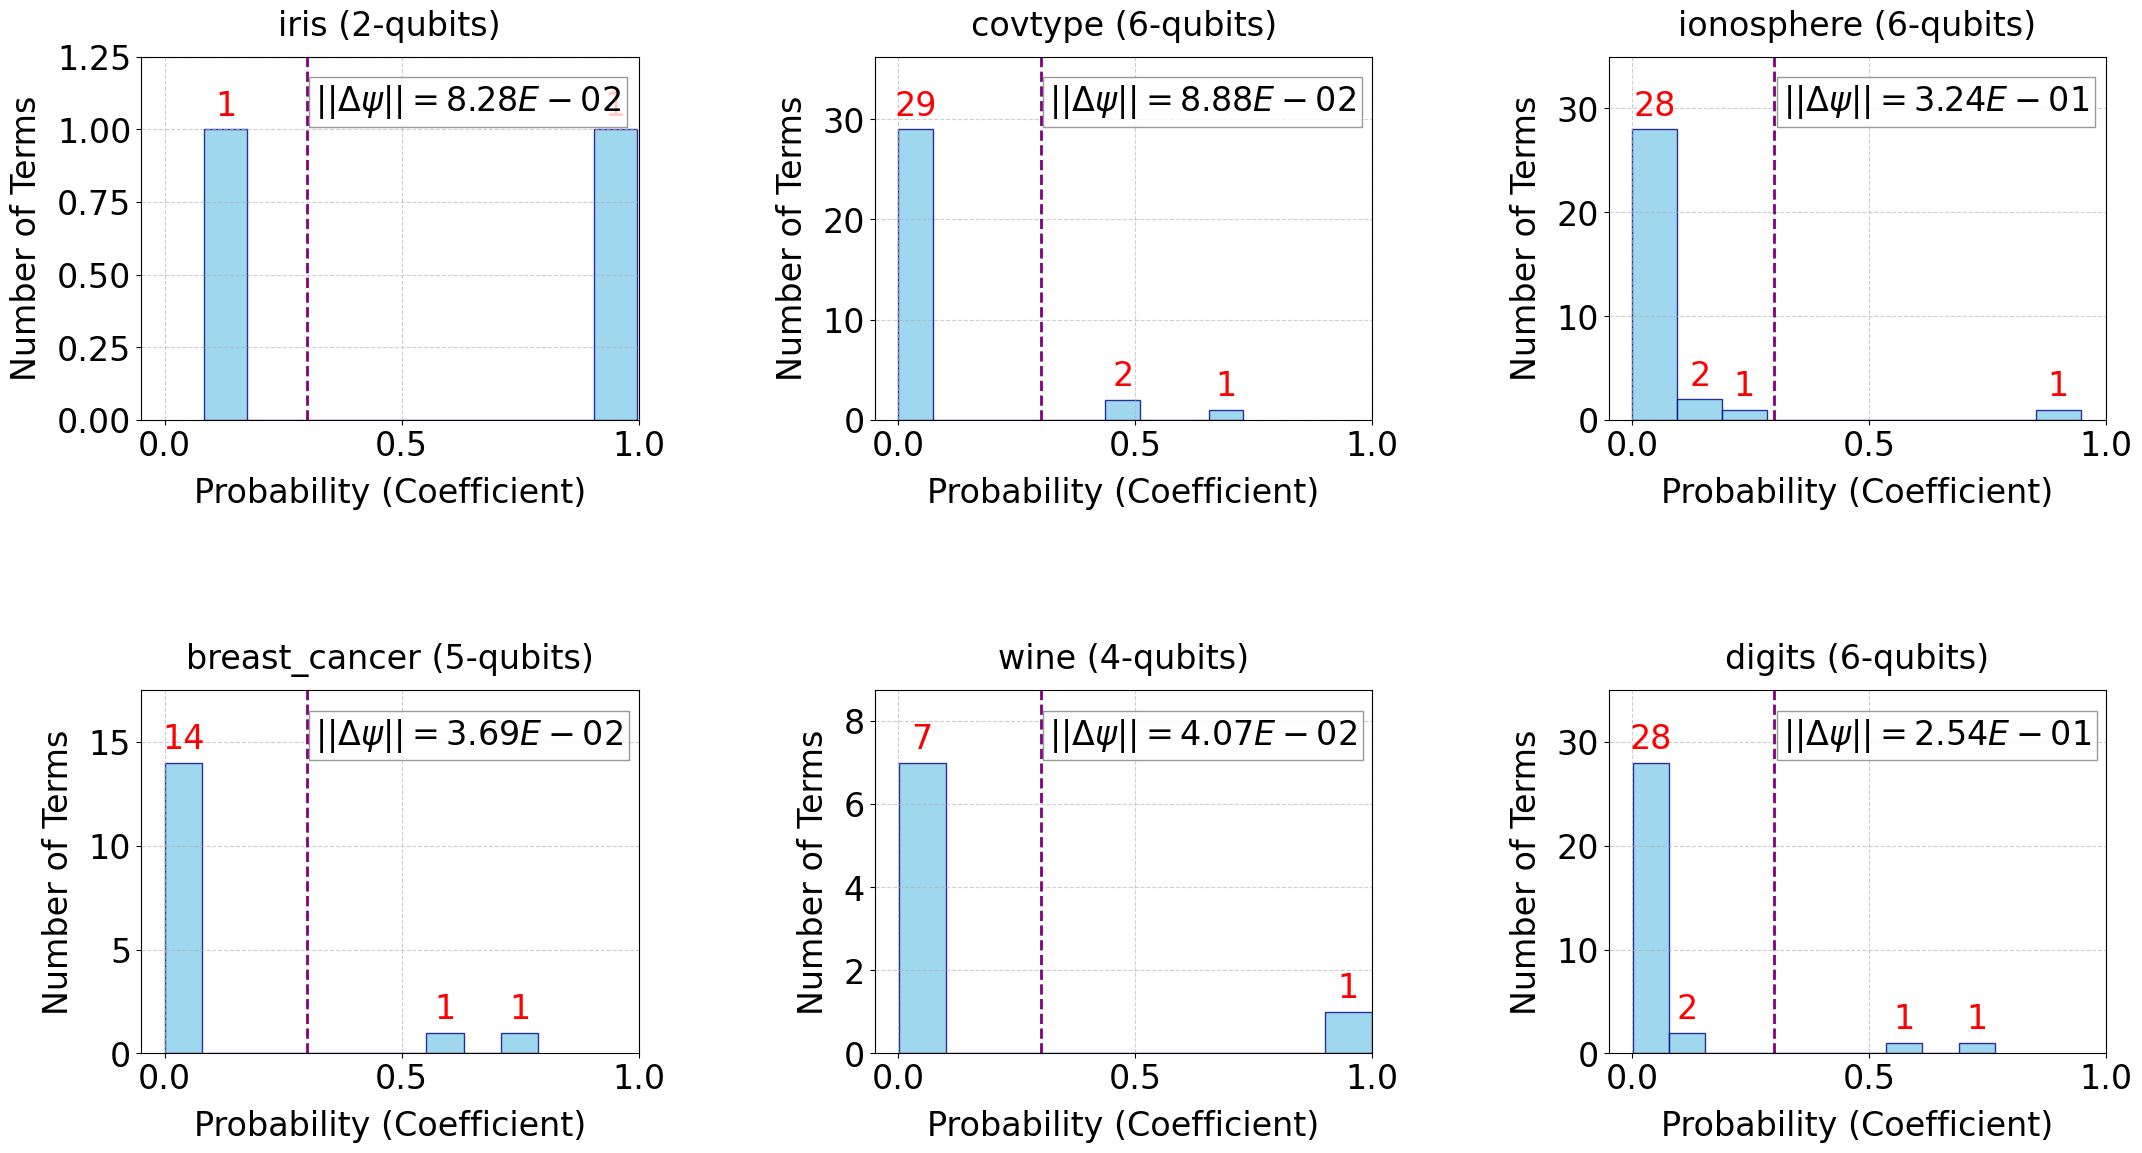

running for the data set lfw_people
for random 100 sample data vectors
n_qubits: 12
running for the data set olivetti_faces
for random 100 sample data vectors
n_qubits: 12
running for the data set diabetes
for random 100 sample data vectors
n_qubits: 3
running for the data set california_housing
for random 100 sample data vectors
n_qubits: 3
running for the data set random5
for random 100 sample data vectors
n_qubits: 5
running for the data set random10
for random 100 sample data vectors
n_qubits: 10


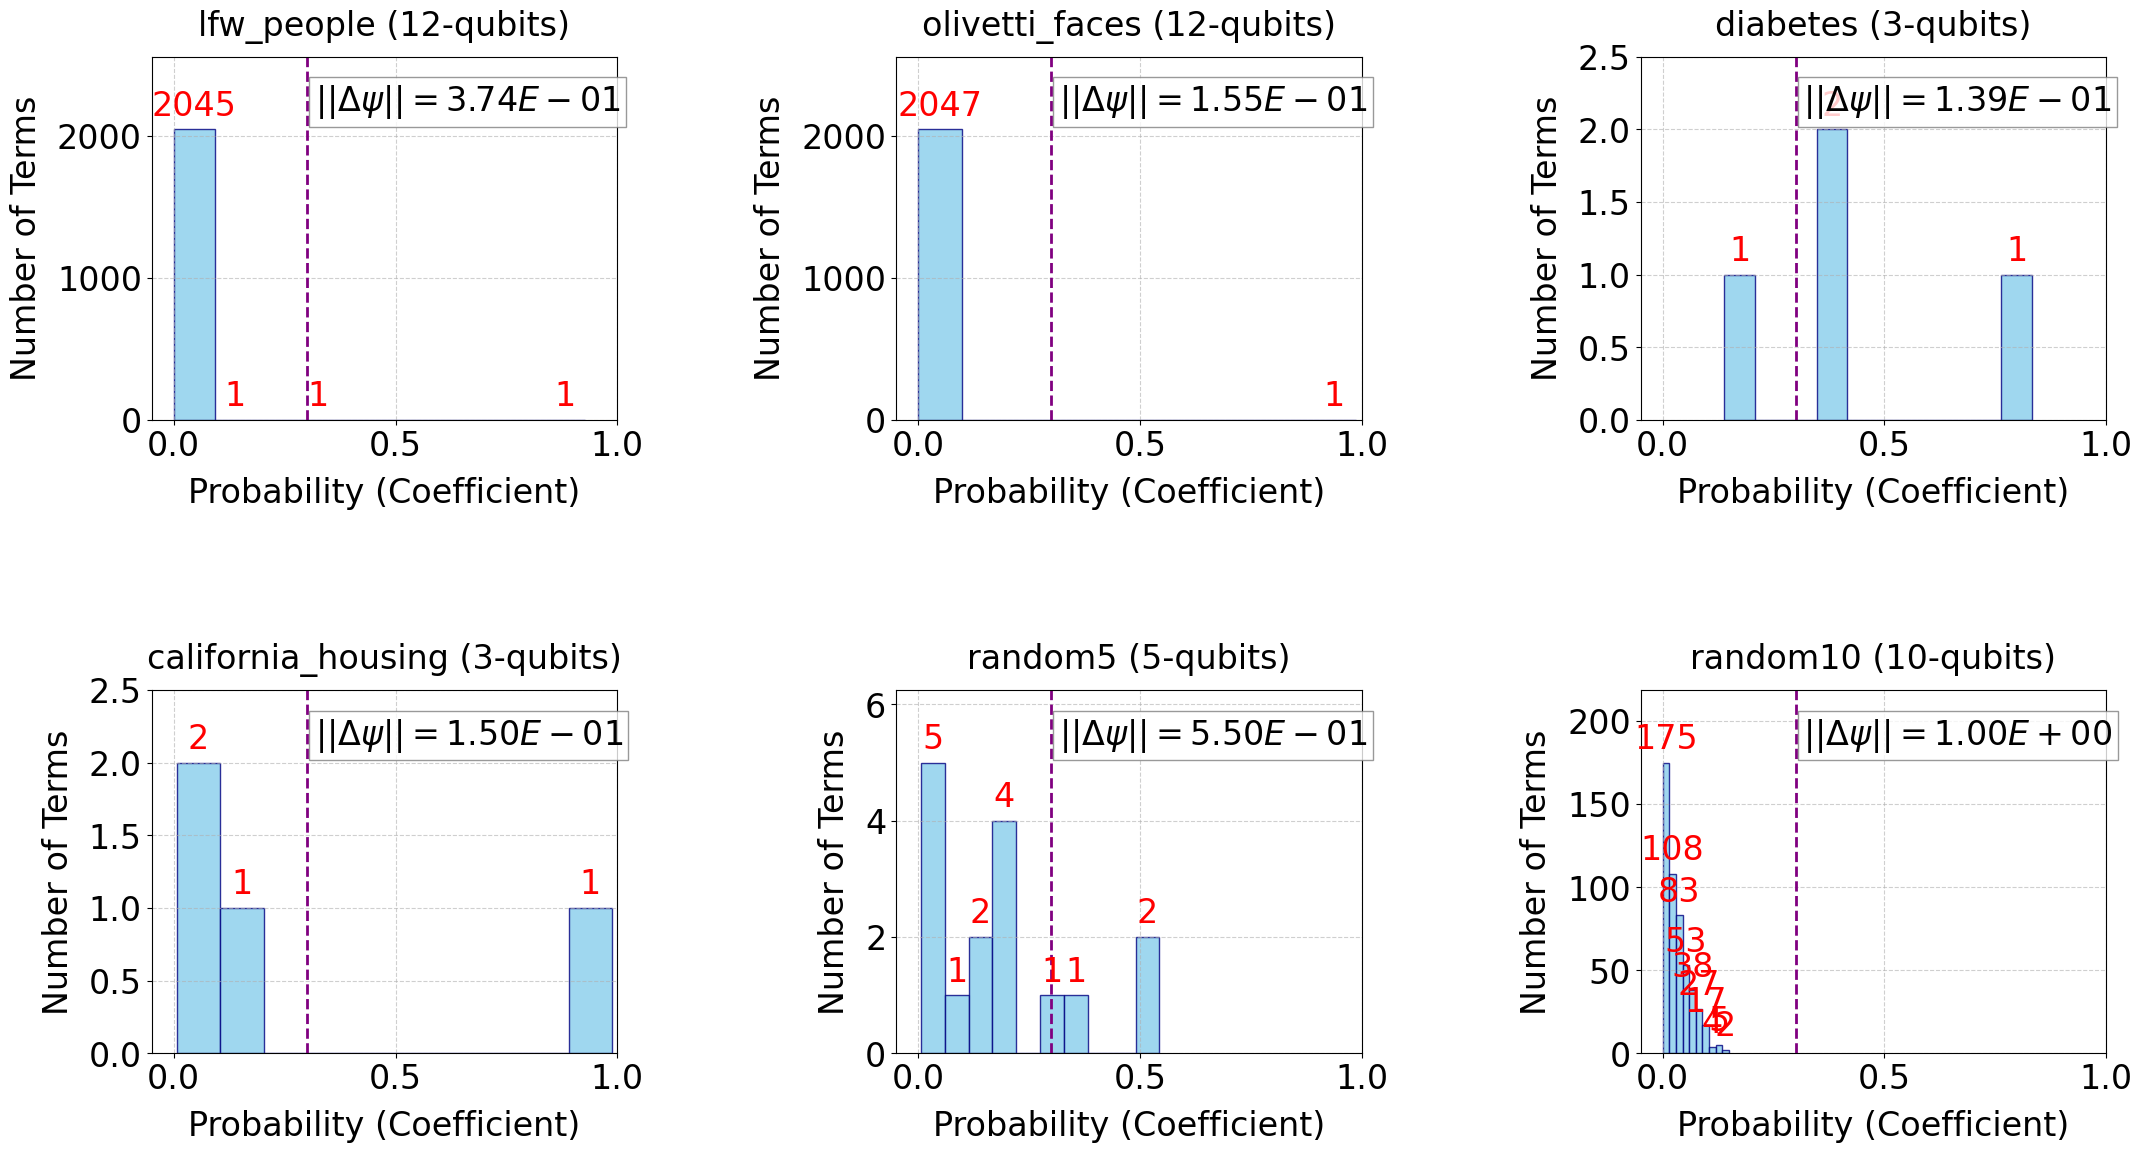

In [ ]:
import numpy as np


class SchmidtDecomposition:
    def __init__(self, threshold: float = 0.05):
        self.threshold = threshold

    def flatten_decomposition(self, state_vector: np.ndarray):
        self.terms = []
        self.coeffs = []
        state = np.asarray(state_vector, dtype=complex).ravel()
        self._decompose(state, coeff=1.0, path=[])
        return self.terms, self.coeffs

    def compute_decomposition(self, state_vector: np.ndarray):
        terms, coeffs = self.flatten_decomposition(state_vector)
        approx = np.zeros_like(state_vector, dtype=complex)
        for term, c in zip(terms, coeffs):
            full = term[0]
            for phi in term[1:]:
                full = np.kron(full, phi)
            approx += c * full
        norm = np.linalg.norm(approx)
        return approx if norm == 0 else approx / norm

    def _decompose(self, state: np.ndarray, coeff: float, path: list):
        size = state.size
        if size == 2:
            if np.linalg.norm(state) < 1e-12:
                return
            c = coeff
            if abs(c) < self.threshold:
                return
            self.terms.append(path + [state.copy()])
            self.coeffs.append(c)
            return

        mat = state.reshape(2, -1)
        U, S, Vh = np.linalg.svd(mat, full_matrices=False)
        for j, s in enumerate(S):
            c = coeff * s
            if abs(c) < self.threshold:
                continue
            phi = U[:, j]
            psi = Vh[j, :]
            self._decompose(psi, c, path + [phi])

    # NEW: Convert Schmidt vectors to rotation angles
    @staticmethod
    def vector_to_angle(vector: np.ndarray) -> float:
        """Convert a 2D quantum state vector to RY rotation angle"""
        # Handle numerical instability
        if np.linalg.norm(vector) < 1e-12:
            return 0.0

        # Normalize and take real parts (assume real-valued states)
        normalized = vector / np.linalg.norm(vector)
        a, b = np.real(normalized)

        # Calculate angle using arctan2 for full quadrant coverage
        return 2 * np.arctan2(b, a)


# --- Reference implementation (as given)
# https://github.com/adaskin/app_with_schmidt/blob/main/sim_tree.py
# ---


def number_of_terms_above_threshold(avec, prob_threshold=0.1):
    number_of_terms = recursive_find_childs(avec, prob_threshold, 1, 0, [])
    return number_of_terms


def find_childs(avec):
    if avec.size <= 2:
        return avec
    A = avec.reshape(2, int(avec.size / 2))
    # print("shape of A:", A.shape, A.size)
    u, s, v = np.linalg.svd(A, full_matrices=False)
    return u, s, v


###########################################################
###########################################################
def recursive_find_childs(avec, minprob, sprev, n0path, listofprobs):
    """
    recursive function to find number of nonzero paths in Schmidt decomposition
    """
    if avec.size <= 2:
        return avec
    n0 = 0
    n1 = 0
    u, s, v = find_childs(avec)

    # print("size:",int(np.log2(v[0,:].size)), s[0]**2)
    if v[0, :].size == 2:
        if sprev * s[0] > minprob:
            n0path += 1

        if sprev * s[1] > minprob:
            n0path += 1
        listofprobs.append(sprev * s[0])
        listofprobs.append(sprev * s[1])
    elif v[0, :].size > 2:
        # print("=======find child v0:sprev*s[0]:{}", sprev*s[0])
        # if(sprev*s[0]>0.000001):
        n0 = recursive_find_childs(v[0, :], minprob, sprev * s[0], n0path, listofprobs)

        # print("=======find child v1==========sprev*s[1]:", sprev*s[1])
        # if(sprev*s[1]>0.000001):
        n1 = recursive_find_childs(v[1, :], minprob, sprev * s[1], n0path, listofprobs)

    n0path += n0 + n1

    return n0path


def generate_tree_elements(avec):
    """ """
    N = avec.size
    if N <= 2:
        return avec
    nonzeropath = 0
    # list of (u,s,v)
    usv_tree = [0] * (N - 1)
    usv_tree[0] = (1, 1, avec, 1)
    level = 0
    u, s, v = find_childs(avec)

    # left child, sprev is the combination of schmidt coeff along the path
    sprev = 1
    usv_tree[1] = (u[:, 0], s[0], v[0], sprev * s[0])
    # right child, sprev is the combination of schmidt coeff along the path
    usv_tree[2] = (u[:, 1], s[1], v[1], sprev * s[1])

    while v.shape[1] > 2:  # level child id
        level += 1
        istart = 2 ** (level) - 1
        iend = istart + 2 ** (level)
        inode = iend
        for i in range(istart, iend):
            # sprev is the combination of schmidt coefficients along the path
            sprev = 0
            if type(usv_tree[i]) != int:
                sprev = usv_tree[i][3]

            # if sprev > 0.0000001: #if prob is too small, skip
            u, s, v = find_childs(usv_tree[i][2])
            # left child,
            usv_tree[inode] = (u[:, 0], s[0], v[0], sprev * s[0])
            # rightchild
            usv_tree[inode + 1] = (u[:, 1], s[1], v[1], sprev * s[1])
            if v.shape[1] == 2:
                nonzeropath += 1
            # print("svd node:{}, addnodes:{},{}".format(i, inode, inode + 1))

            inode += 2

    return usv_tree, nonzeropath


###########################################################


def check_usv_tree(usv_tree):
    """check the correctness of the tree nodes"""
    for i in range(0, int(len(usv_tree) / 2)):
        ui, si, vi, sprevi = usv_tree[i]
        ur, sr, vr, sprevr = usv_tree[2 * i + 1]
        ul, sl, vl, sprevl = usv_tree[2 * i + 2]
        avec = np.kron(sr * ur, vr) + np.kron(sl * ul, vl)
        diff = np.linalg.norm(vi - avec)
        if diff > 0.000001:
            # print(i, diff)
            return -1
    return 0


def tree_with_nonzero_paths(avec, prob_threshold):
    """ """
    if avec.size <= 2:
        return avec
    nonzeropath = 0
    # list of (u,s,v)
    usv_tree = [0] * (avec.size - 1)  # |0|1|2|3|4|...|N-2|

    usv_tree[0] = (1, 1, avec, 1)
    level = 0
    u, s, v = find_childs(avec)

    # left child, sprev is the combination of schmidt coeff along the path
    sprev = 1
    usv_tree[1] = (u[:, 0], s[0], v[0], sprev * s[0])
    # right child, sprev is the combination of schmidt coeff along the path
    usv_tree[2] = (u[:, 1], s[1], v[1], sprev * s[1])

    while v.shape[1] > 2:  # level child id
        level += 1
        istart = 2 ** (level) - 1
        iend = istart + 2 ** (level)
        inode = iend
        for i in range(istart, iend):
            # sprev is the combination of schmidt coefficients along the path
            sprev = 0
            if type(usv_tree[i]) != int:
                sprev = usv_tree[i][3]

            if sprev > prob_threshold:  # if prob is too small, skip
                u, s, v = find_childs(usv_tree[i][2])
                # left child,
                usv_tree[inode] = (u[:, 0], s[0], v[0], sprev * s[0])
                # rightchild
                usv_tree[inode + 1] = (u[:, 1], s[1], v[1], sprev * s[1])
                if v.shape[1] == 2:
                    nonzeropath += 1
                # print("svd node:{}, addnodes:{},{}".format(i, inode, inode + 1))
            inode += 2

    return usv_tree, nonzeropath


def sum_of_nonzeropaths(usv_tree, prob_threshold):
    """
    remove paths that has the coefficient less than
    prob_threshold
    """
    tlen = len(usv_tree)
    sum_of_paths = 0
    path_vec = 0
    npaths = 0  # number of nonzero paths
    for i in range(int(tlen / 2), tlen):
        if isinstance(usv_tree[i], tuple):
            ui, si, vi, sprevi = usv_tree[i]
            # TODO: we can combine nodes with the same parents
            if sprevi >= prob_threshold:
                path_vec = vi
                inode = i
                # go up from leaf node to the root
                while inode > 0:
                    unode, snode, vnode, sprevnode = usv_tree[inode]
                    path_vec = np.kron(snode * unode, path_vec)
                    if inode % 2 == 1:
                        inode = int(inode / 2)  # e.g. inode 7->3
                    else:
                        inode = int((inode - 1) / 2)  # eg inode 8->3
                    # print("i and inode", i, inode)
                sum_of_paths += path_vec
                npaths += 1
    return sum_of_paths, npaths


def ref_reconstruct(state, threshold):
    tree, _ = tree_with_nonzero_paths(state, threshold)
    summed, _ = sum_of_nonzeropaths(tree, threshold)
    norm = np.linalg.norm(summed)
    return summed if norm == 0 else summed / norm


def qft(N):
    """
    generates quantum fourier transform matrix of dimension N=2^n
    N: dimension
    """
    w = np.exp(2 * np.pi * 1j / N)
    A = np.zeros([N, N], dtype="complex")
    for i in range(0, N):
        for j in range(0, N):
            A[i, j] = w ** (j * i) / N
    # print("shape of A:", A.shape)
    return A


def test_schmidt_qft_equivalence():
    n = 6
    dim = 2**n
    # pick QFT|0> instead of flattening the full matrix
    psi = qft(dim).flatten()
    psi /= np.linalg.norm(psi)

    threshold = 0.00125
    sd = SchmidtDecomposition(threshold=threshold)
    approx_ours = sd.compute_decomposition(psi)
    approx_ref = ref_reconstruct(psi, threshold)

    print(
        "terms kept:",
        len(sd.flatten_decomposition(psi)[0]),
        number_of_terms_above_threshold(psi, threshold),
    )
    print("‖ψ - this‖ :", np.linalg.norm(psi - approx_ours))
    print("‖ψ - ref‖  :", np.linalg.norm(psi - approx_ref))
    print("‖this - ref‖:", np.linalg.norm(approx_ours - approx_ref))

    assert np.allclose(approx_ours, approx_ref, atol=1e-6), "a mismatch!"


def run_draw(psi, threshold=0.1, fig_name="fig_schmidt_decom", data_name="data"):
    from matplotlib import pyplot as plt

    print("=================================================================\n\n")
    (usv_tree, nonzeropath) = generate_tree_elements(psi)

    """
    the nodes on usv_tree: |0|1|2|3|4|...|14|empty]
    
    """
    L = []
    for i in range(int(psi.size / 2) - 1, psi.size - 1):
        if isinstance(usv_tree[i], tuple):
            u, s, v, sprev = usv_tree[i]
            # print("shape:", v.shape)
            L.append(usv_tree[i][3])
        else:
            L.append(0)
    fig, ax = plt.subplots()
    ax.axvline(threshold, linestyle="--")
    values, bins, bars = ax.hist(L)

    ax.set_xlabel("probability (coefficient) of the term")
    ax.set_ylabel("Number of terms")
    ax.set_title(f"n: {int(np.log2(psi.size))}-qubits, data: {data_name}")
    ax.bar_label(bars, fontsize=9, color="red")

    p, npaths = sum_of_nonzeropaths(usv_tree, threshold)
    norm_of_diff = np.linalg.norm(psi - p)
    print("norm diff with the cutoff", norm_of_diff)
    ax.text(
        0.75,
        0.75,
        "norm of diff={:5.2E}".format(norm_of_diff),
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

    plt.savefig(f"{fig_name}.pdf", bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", bbox_inches="tight")


def run_draw_list(
    psi_list, thresholds=None, fig_name="fig_schmidt_decom", data_names=None
):
    from matplotlib import pyplot as plt
    import numpy as np
    import matplotlib as mpl

    # Validate input lengths
    # if len(psi_list) != 6:
    # raise ValueError("psi_list must contain exactly 6 wavefunctions")
    if thresholds is None:
        thresholds = [0.1] * len(psi_list)
    if data_names is None:
        data_names = ["data"] * len(psi_list)

    # Configure global font settings
    mpl.rcParams.update(
        {
            "font.size": 24,
            "axes.titlesize": 24,
            "axes.labelsize": 24,
            "xtick.labelsize": 24,
            "ytick.labelsize": 24,
            "legend.fontsize": 24,
        }
    )

    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    axs = axs.flatten()

    for i, (psi, threshold, data_name) in enumerate(
        zip(psi_list, thresholds, data_names)
    ):
        ax = axs[i]
        print("=================================================================")

        # Generate tree elements and compute probabilities
        (usv_tree, nonzeropath) = generate_tree_elements(psi)
        L = []
        for j in range(int(psi.size / 2) - 1, psi.size - 1):
            if isinstance(usv_tree[j], tuple):
                L.append(usv_tree[j][3])  # Extract probability
            else:
                L.append(0)

        # Create histogram with enhanced styling
        ax.axvline(threshold, linestyle="--", color="purple", lw=2)
        values, bins, bars = ax.hist(
            L, bins=10, color="skyblue", edgecolor="navy", alpha=0.8
        )

        # Create custom labels - only show non-zero values
        custom_labels = []
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                # Format as integer if whole number, otherwise keep 1 decimal
                if height.is_integer():
                    custom_labels.append(f"{int(height)}")
                else:
                    custom_labels.append(f"{height:.1f}")
            else:
                custom_labels.append("")  # Empty string for zero values

        # Add bar labels with improved positioning
        ax.bar_label(
            bars,
            labels=custom_labels,  # Use our custom labels
            fontsize=24,
            color="red",
            padding=5,
            label_type="edge",
        )

        # Set axis limits to focus on key region
        ax.set_xlim(-0.05, 1)
        ax.set_ylim(0, max(values) * 1.25)  # Add headroom for bar labels

        # Add labels and title with larger fonts
        ax.set_xlabel("Probability (Coefficient)", fontsize=24, labelpad=10)
        ax.set_ylabel("Number of Terms", fontsize=24, labelpad=10)
        n_qubits = int(np.log2(psi.size))
        ax.set_title(f"{data_name} ({n_qubits}-qubits)", fontsize=24, pad=15)

        # Add norm difference annotation
        p, npaths = sum_of_nonzeropaths(usv_tree, threshold)
        norm_of_diff = np.linalg.norm(psi - p)
        ax.text(
            0.35,
            0.85,
            f"$||\\Delta\\psi|| = {norm_of_diff:.2E}$",
            transform=ax.transAxes,
            fontsize=24,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"),
        )

        # Add grid for readability
        ax.grid(True, linestyle="--", alpha=0.6)

    # Adjust layout with extra spacing
    plt.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)

    # Save high-resolution figures
    plt.savefig(f"{fig_name}.pdf", dpi=300, bbox_inches="tight")
    plt.savefig(f"{fig_name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def run_for_data_samples():
    from data_loaders import load_dataset

    datasets = [
        "iris",
        "covtype",
        "ionosphere",
        "breast_cancer",
        "wine",
        "digits",]

    all_results = {}
    sample_size = 100
    vecs = []
    data_names = []
    threshold = []
    for ds in datasets:
        print("=" * 40)
        print(
            f"running for the data set {ds}\n"
            f"for random {sample_size} sample data vectors"
        )
        X, y, n_qubits, n_classes = load_dataset(ds)
        sample_indices = np.random.choice(
            len(X), size=min(sample_size, len(X)), replace=False
        )
        mean_vec = X[sample_indices].mean(axis=0)
        vecs.append(mean_vec / np.linalg.norm(mean_vec))
        data_names.append(ds)
        threshold.append(0.3)

    run_draw_list(vecs, thresholds=threshold, data_names=data_names)


    datasets = [
        "lfw_people",
        "olivetti_faces",
        "diabetes",
        "california_housing",
        "random5",
        "random10",
    ]
    all_results = {}
    sample_size = 100
    vecs = []
    data_names = []
    threshold = []
    for ds in datasets:
        print("=" * 40)
        print(
            f"running for the data set {ds}\n"
            f"for random {sample_size} sample data vectors"
        )
        X, y, n_qubits, n_classes = load_dataset(ds)
        sample_indices = np.random.choice(
            len(X), size=min(sample_size, len(X)), replace=False
        )
        mean_vec = X[sample_indices].mean(axis=0)
        vecs.append(mean_vec / np.linalg.norm(mean_vec))
        data_names.append(ds)
        threshold.append(0.3)

    run_draw_list(vecs, thresholds=threshold, data_names=data_names,fig_name="fig_schmidt_decom2")
    return all_results


if __name__ == "__main__":
    # test_schmidt_qft_equivalence()
    # print("✅ QFT test passed!")
    run_for_data_samples()